# Overview
This dataset contains information about users and transactions form a E-commerse site. The goal of this challege is to explore patterns using data visualizations and come up with a machine learning model which can predict whether a transaction of a user is fradulent of not.

### 1. Data Processing and Feature Engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fraud = pd.read_csv("Fraud_Data.csv")
ip_country = pd.read_csv("IpAddress_to_Country.csv")

In [3]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
ip_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [5]:
#Add country feature based on the ip address
countries = []
for index, row in fraud.iterrows():
    ip = row["ip_address"]
    country = ip_country[(ip_country['lower_bound_ip_address'] <= ip) &
                          (ip_country['upper_bound_ip_address'] >= ip)]
    if len(country) == 1:
        countries.append(country['country'].iloc[0])
    else:
        countries.append(np.nan)


In [6]:
fraud.loc[:,"country"] = countries
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [7]:
fraud.isnull().mean()

user_id           0.000000
signup_time       0.000000
purchase_time     0.000000
purchase_value    0.000000
device_id         0.000000
source            0.000000
browser           0.000000
sex               0.000000
age               0.000000
ip_address        0.000000
class             0.000000
country           0.145362
dtype: float64

There are 15 percent of missing data for country.

In [8]:
fraud[fraud["country"].isna()]["user_id"].value_counts()

4094      1
322280    1
27352     1
254681    1
217823    1
         ..
224981    1
394570    1
76808     1
173390    1
198657    1
Name: user_id, Length: 21966, dtype: int64

In [9]:
fraud.loc[fraud["country"].isna(),"country"] = "NA"

In [10]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


We can add time differences between sign up time and purchase time as one feature, since the lag might indicate the probability of fraudulent activities. We can also extract weekday and hour information from signup and purchase time.

In [11]:
fraud.loc[:,'signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud.loc[:,'purchase_time'] = pd.to_datetime(fraud['purchase_time'])

In [12]:
# Signup weekday and hour
fraud.loc[:,'signup_day'] = fraud['signup_time'].apply(lambda x: x.weekday()).astype(str)
fraud.loc[:,'signup_hour'] = fraud['signup_time'].apply(lambda x: x.hour).astype(str)
# Purchase weekday and hour
fraud.loc[:,'purchase_day'] = fraud['purchase_time'].apply(lambda x: x.weekday()).astype(str)
fraud.loc[:,'purchase_hour'] = fraud['purchase_time'].apply(lambda x: x.hour).astype(str)

In [13]:
#time difference in seconds
fraud.loc[:,'time diff'] =  (fraud['purchase_time']-fraud['signup_time']).dt.seconds

### 2. EDA and Additional Feature Engineer

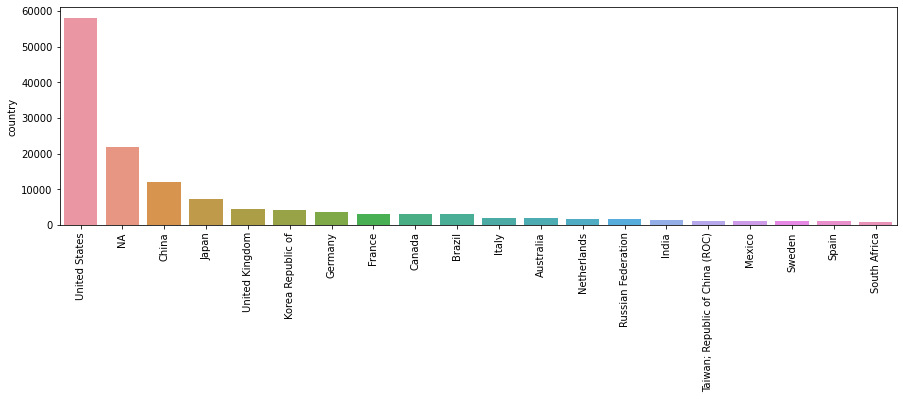

In [14]:
#distribution of top countries
plt.figure(figsize=(15,4))
cty = fraud["country"].value_counts().head(20)
sns.barplot(cty.index, cty)
a=plt.xticks(rotation = 90)

#### We want to focus on patterns related to fraud vs. non-fraud":
- Distribution of time differences by fraud
- Distribution of age by fraud
- Distribution of purchase week and hour by fraud

<AxesSubplot:xlabel='class', ylabel='time diff'>

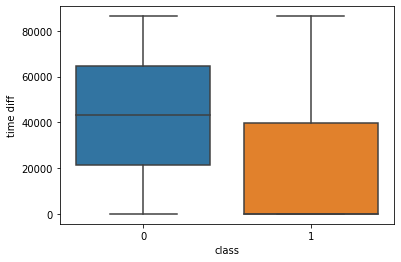

In [15]:
# median of class 1 is almost 0, most fraud cases have very short time lag
sns.boxplot("class","time diff",data = fraud)

<AxesSubplot:xlabel='class', ylabel='age'>

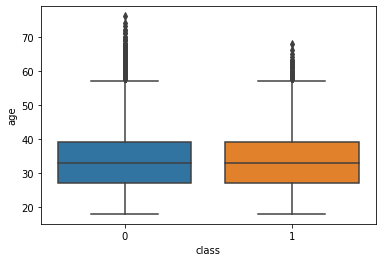

In [26]:
#No significant differences between ages of users
sns.boxplot("class","age",data = fraud)

<AxesSubplot:xlabel='purchase_day', ylabel='purchase_value'>

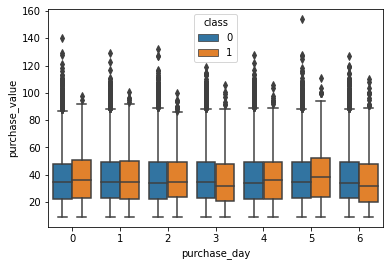

In [17]:
#Fraud cases generally have a higher median purchase value, but not on every weekday
sns.boxplot("purchase_day","purchase_value",data = fraud,hue="class")

<AxesSubplot:xlabel='purchase_hour', ylabel='purchase_value'>

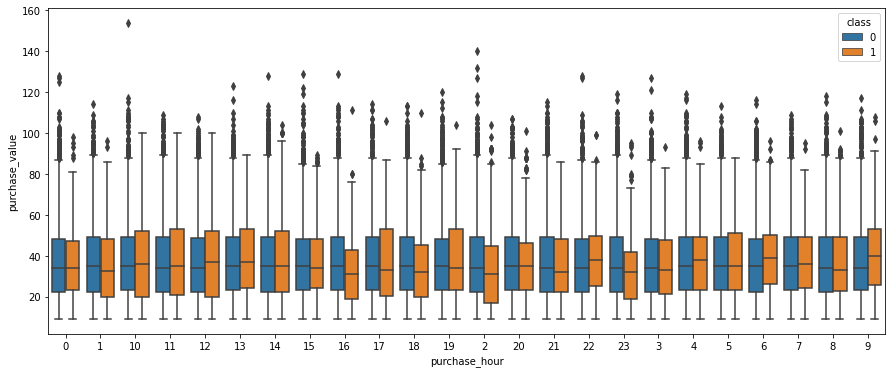

In [18]:
#Fraud cases generally have a higher median purchase value across hours
plt.figure(figsize=(15,6))
sns.boxplot("purchase_hour","purchase_value",data = fraud,hue="class")

In [19]:
#distribution of fraud countries: 110 countries had fraud cases
class_1 = fraud[fraud["class"]==1]
cty_1 = class_1["country"].value_counts()
len(cty_1)

110

In [20]:
#Out of 137956 total devices, 6175 of them are associated with more than one activity
len(fraud["device_id"].value_counts()[fraud["device_id"].value_counts()!=1])

6175

In [21]:
#Out of 6987 devices with fraud, 1044 of them associated with more than one activity
len(class_1["device_id"].value_counts()[class_1["device_id"].value_counts()!=1])

1044

In [31]:
max(class_1["device_id"].value_counts()[class_1["device_id"].value_counts()!=1])
#for fraud cases, the maximum number of users involved is 19, 19 rows of that device were fraudulent

19

In [29]:
class_0 = fraud[fraud["class"]==0]
cty_0 = class_0["country"].value_counts()
max(class_0["device_id"].value_counts()[class_0["device_id"].value_counts()!=1])

3

In [35]:
#add a feature of duplicate devices might help with prediction
#the number of users associated with a device increases the probability of fraud
device_df = fraud["device_id"].value_counts().to_frame().reset_index()
device_df = device_df.rename(columns={"index":"device_id","device_id":"device_count"})
device_df.head()

,device_id,device_count
0,ZUSVMDEZRBDTX,20
1,CQTUVBYIWWWBC,20
2,NGQCKIADMZORL,20
3,EQYVNEGOFLAWK,20
4,KIPFSCNUGOLDP,20


In [47]:
#create a new df named data as the final name
data = pd.merge(fraud,device_df,on ="device_id" )
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_day,signup_hour,purchase_day,purchase_hour,time diff,device_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,22,5,2,13882,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,6,20,0,1,17944,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,3,18,3,18,1,12
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,3,18,3,18,1,12
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,3,18,3,18,1,12


<AxesSubplot:xlabel='class', ylabel='0'>

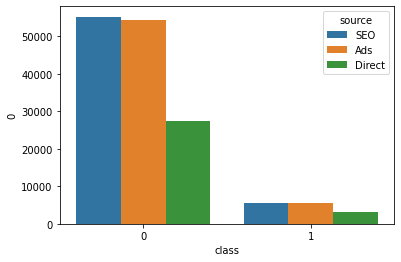

In [48]:
source = fraud[["source","class"]].value_counts().to_frame().reset_index()
sns.barplot("class",0,data=source, hue="source")

<AxesSubplot:xlabel='class', ylabel='0'>

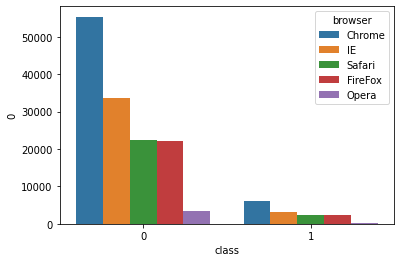

In [49]:
browser = fraud[["browser","class"]].value_counts().to_frame().reset_index()
sns.barplot("class",0,data=browser, hue="browser")

In [50]:
#same device, different browser/source
data.groupby(["device_id","browser"]).size()

device_id      browser
AAALBGNHHVMKG  Chrome      1
AAAWIHVCQELTP  Chrome      1
AAAXJHWCLISKY  IE          1
AAAXXOZJRZRAO  FireFox    11
AABFGRPBQHWFQ  Opera       1
                          ..
ZZZGSIJRNCXBJ  Safari      1
ZZZIKLJSVSQMF  IE          1
ZZZKJIZHJEDFN  Safari      1
ZZZMVOGBAJVTM  Chrome      1
ZZZXASJUVUNMV  Chrome      1
Length: 141973, dtype: int64

In [51]:
#ip address counts
data["ip_address"].value_counts().head(5)

5.760609e+08    20
2.050964e+09    20
3.874758e+09    20
1.502818e+09    20
1.800550e+09    19
Name: ip_address, dtype: int64

In [52]:
#the number of users associated with the same ip increases the probability of fraud
ip_df = data["ip_address"].value_counts().to_frame().reset_index()
ip_df = ip_df.rename(columns={"index":"ip_address","ip_address":"ip_count"})
ip_df.head()

,ip_address,ip_count
0,5.760609e+08,20
1,2.050964e+09,20
2,3.874758e+09,20
3,1.502818e+09,20
4,1.800550e+09,19


In [53]:
data = pd.merge(data,ip_df,on ="ip_address" )
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,signup_day,signup_hour,purchase_day,purchase_hour,time diff,device_count,ip_count
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,22,5,2,13882,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,6,20,0,1,17944,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,3,18,3,18,1,12,12
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,3,18,3,18,1,12,12
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,3,18,3,18,1,12,12


### Classification

In [54]:
from sklearn.model_selection import train_test_split

In [57]:
X = data[["purchase_value","age","signup_day","signup_hour","purchase_day","purchase_hour","time diff","device_count","ip_count"]]

In [58]:
y=data["class"]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [64]:
preds = rf.predict(X_test)

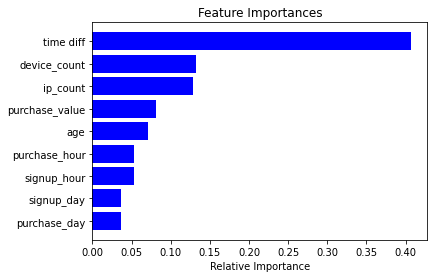

In [69]:
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [71]:
importances

array([0.081729  , 0.07144264, 0.03682441, 0.05298811, 0.03639626,
       0.05344088, 0.40729409, 0.13169053, 0.12819408])

Not surprisingly, the most important feature is the difference between signup and purchase time.

In [72]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_roc_curve

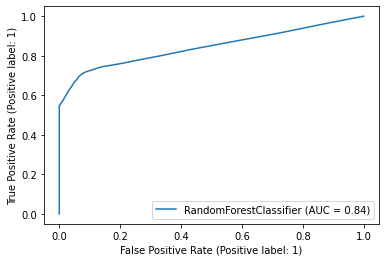

In [73]:
plot_roc_curve(rf,X=X_test,y=y_test)

In [76]:
#precision, recall and f1 score based on the model and default threshold
precision_recall_fscore_support(y_test,preds)

(array([0.95542209, 0.98759209]),
 array([0.99929222, 0.5471536 ]),
 array([0.97686486, 0.70417473]),
 array([45212,  4655]))

For class 1 the recall is only 0.55, but the area under the curve is decent. For fraud cases we might want to minimize false negatives (fraud classified as non-fraud) or maximize true positives, we want to choose a threshold where true positive rate is good, which means we might decrease the threshold.